In [3]:
! chmod +x install.sh
!./install.sh

Found existing installation: tensorflow-gpu 2.2.0
Uninstalling tensorflow-gpu-2.2.0:
  Successfully uninstalled tensorflow-gpu-2.2.0
  Using cached tensorflow_gpu-2.2.0-cp37-cp37m-manylinux2010_x86_64.whl (516.2 MB)
Requirement already up-to-date: tensorflow_datasets in /opt/conda/lib/python3.7/site-packages (4.0.1)
Requirement already up-to-date: efficientnet in /opt/conda/lib/python3.7/site-packages (1.1.1)


In [4]:
import re
import pickle
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
from kaggle_datasets import KaggleDatasets
from tensorflow.keras import layers
import tensorflow.keras.backend as K

Tensorflow version 2.2.0


In [2]:
from consts import *
from dataset_utils import *

In [3]:
if not is_debug:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=os.environ['TPU_NAME'])
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    strategy = tf.distribute.experimental.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [4]:
from collections import namedtuple
config=namedtuple('config',['lr_max','lr_start','lr_warm_up_epochs','lr_min','lr_exp_decay','nfolds','l2_penalty','model_fn_str','work_dir','ttas'])

CONFIG=config(lr_max=0.0002*8, lr_start=0.0002*8, lr_warm_up_epochs=0, lr_min=0.000005,lr_exp_decay=0.8, nfolds=4,l2_penalty=1e-6, work_dir='b6_focal_loss_768',
              model_fn_str="efficientnet.tfkeras.EfficientNetB6(weights='imagenet', include_top=False)", ttas=1)


#pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
# EfficientNet can be loaded through efficientnet.tfkeras library (https://github.com/qubvel/efficientnet)

if not os.path.exists(CONFIG.work_dir):
    os.mkdir(CONFIG.work_dir)
    
with open(os.path.join(CONFIG.work_dir,'config.pkl'),'wb') as file:
    pickle.dump(CONFIG,file)


Learning rate schedule: 0.0016 to 0.0016 to 0.00103


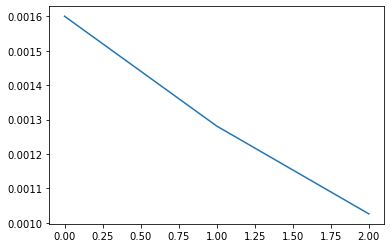

In [6]:
from lr import get_lrfn

lrfn=get_lrfn(CONFIG)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [7]:
train_filenames_folds, val_filenames_folds=get_train_val_filenames(DATASETS[IMAGE_HEIGHT],CONFIG.nfolds)
test_filenames=get_test_filenames(DATASETS[IMAGE_HEIGHT])
if is_debug:
    #test_filenames=[test_filenames[0]]
    train_filenames_folds=[[f[0]] for f in train_filenames_folds]
    val_filenames_folds=[[f[0]] for f in val_filenames_folds]
fold=0
training_dataset = get_training_dataset(train_filenames_folds[fold])
validation_dataset = get_validation_dataset(val_filenames_folds[fold])
test_dataset = get_test_dataset(test_filenames)
test_dataset_tta = get_test_dataset_tta(test_filenames)

[0 0 0 0 0 0 0 0 0]


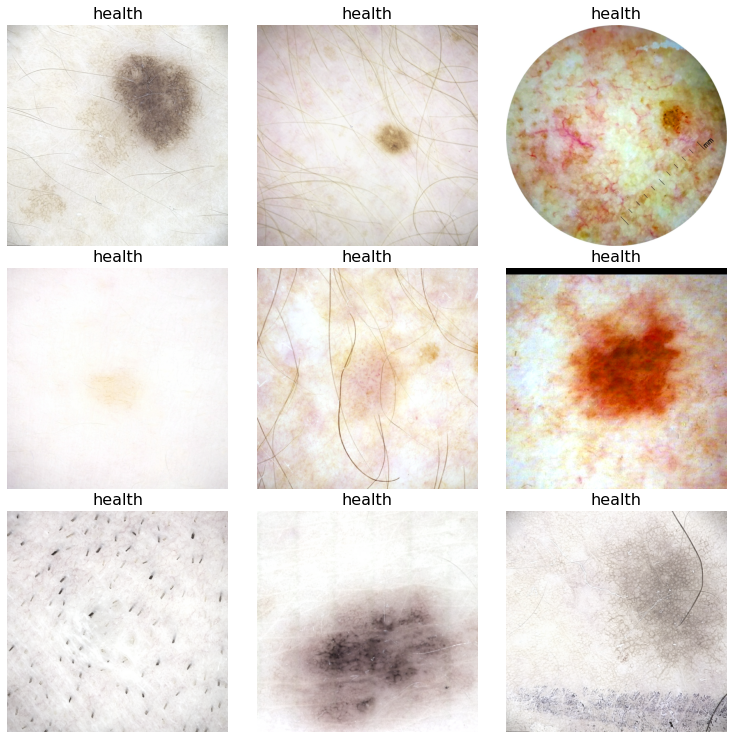

In [11]:
display_9_images_from_dataset(return_2_values(test_dataset_tta))

[0 0 0 0 0 0 0 0 0]


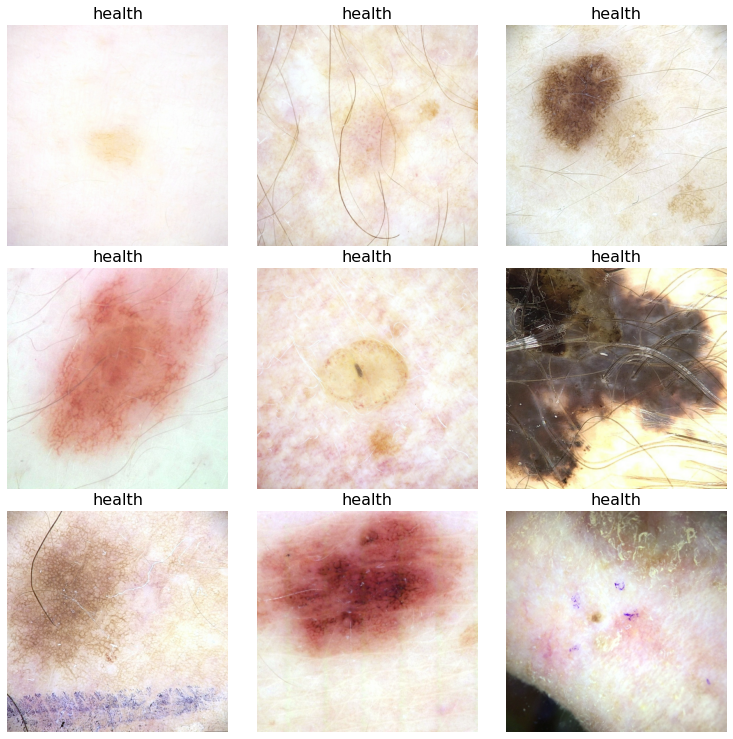

In [12]:
display_9_images_from_dataset(return_2_values(test_dataset))

[0 0 0 0 0 0 0 0 0]


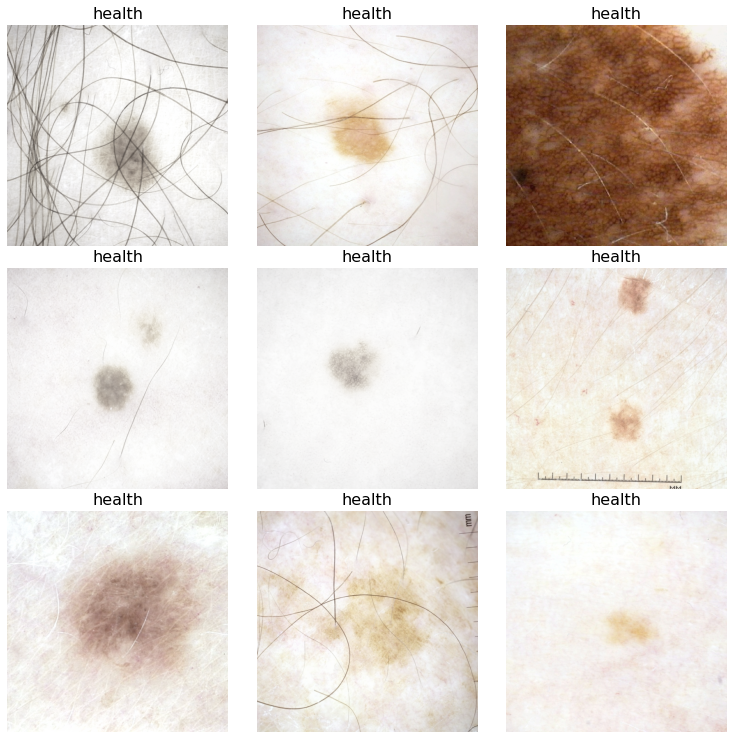

In [13]:
display_9_images_from_dataset(return_2_values(training_dataset))

In [14]:
import importlib
import submission
importlib.reload(submission)


<module 'submission' from '/home/jupyter/submission.py'>

In [15]:
from create_model import BinaryFocalLoss
from create_model import create_model

In [ ]:
for fold in range(CONFIG.nfolds):
    print(f'fold={fold}')
    
    if is_debug:
        model = create_model(CONFIG)
    else:
        with strategy.scope():
            model = create_model(CONFIG)

    model.summary()
    training_dataset = get_training_dataset(train_filenames_folds[fold])
    validation_dataset = get_validation_dataset(val_filenames_folds[fold])
    
    history = model.fit(return_2_values(training_dataset), validation_data=return_2_values(validation_dataset),
                        steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=[lr_callback])

    final_accuracy = history.history["val_accuracy"][-5:]
    print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
    model.save(f'{CONFIG.work_dir}/model{fold}.h5')
    
    display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
    display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)
    
    validation_dataset = get_validation_dataset(val_filenames_folds[fold])
    validation_dataset_tta = get_validation_dataset_tta(val_filenames_folds[fold])
    
    submission.calc_and_save_submissions(CONFIG,model,f'val_{fold}',validation_dataset, validation_dataset_tta, CONFIG.ttas)
    submission.calc_and_save_submissions(CONFIG,model,f'test_{fold}',test_dataset, test_dataset_tta,CONFIG.ttas)
    
    K.clear_session()

fold=0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, None, None, 2304)  40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4610      
Total params: 40,964,746
Trainable params: 40,740,314
Non-trainable params: 224,432
_________________________________________________________________

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0016.
Epoch 1/3
390/390 [==============================] - 874s 2s/step - auc: 0.9901 - accuracy: 0.9798 - loss: 0.4408 - val_auc: 0.9934 - val_accuracy: 0.9825 - val_loss: 0.3784 - lr: 0.0016

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0012810000000000002.
Epoch 2/3
390/390 [

In [ ]:
import importlib
import submission
importlib.reload(submission)

In [17]:
model=tf.keras.models.load_model('/home/jupyter/b6_focal_loss_768/model0.h5',compile=False)

In [18]:
model.compile(
        optimizer='adam',
        loss = BinaryFocalLoss(),#'categorical_crossentropy',#loss_fn
        metrics=['accuracy',tf.keras.metrics.AUC()]
    )

In [ ]:
submission.calc_and_save_submissions(CONFIG,model,f'tmp_{fold}',test_dataset, test_dataset_tta)

39it [31:16, 48.01s/it]

In [ ]:
from sklearn import metrics
def calc_auc(subm):
    preds=subm['target'].values
    labels=subm['labels'].values
    return metrics.roc_auc_score(labels, preds)

In [ ]:
src=CONFIG.work_dir

for m_type in ['','tta_']:
    a=[]

    for fold in range(CONFIG.nfolds):
        sub=pd.read_csv(os.path.join(src,f'val_{fold}_single_model_{m_type}submission.csv'))
        a.append(calc_auc(sub))
    print(f'single_model_{m_type}metrics={a}')
    print(f'single_model_{m_type}avg_metric={np.mean(a)}')
    

In [ ]:
def save_submission(df,name):
    df_submission=df[['image_name','target']]
    
    df_submission.to_csv(name, index=False )
    os.system(f'kaggle competitions submit -c siim-isic-melanoma-classification -f {name} -m {name}')

In [ ]:
for m_type in ['','tta_']:
    a=[]
    subs=[]
    for fold in range(CONFIG.nfolds):
        name=f'test_{fold}_single_model_{m_type}submission.csv'
        sub=pd.read_csv(os.path.join(src,name))
        save_submission(sub,os.path.join(src,'kaggle_'+name))
        subs.append(sub)
    avg_sub=submission.avg_submissions(subs)
    save_submission(avg_sub,os.path.join(src,'kaggle_'+f'test_{m_type}.csv'))
    

In [17]:
model.

In [29]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.7/site-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 562, in competition_submit_cli
    competition, quiet)
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 513, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/opt/conda/lib/python3.7/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'artifacts//submission.csv'


In [19]:
!$PWD

/bin/sh: 1: /home/jupyter: Permission denied
